<a href="https://colab.research.google.com/github/ejara42/Data-Preprocessing-for-ML-using-Titanic-Dataset/blob/main/tree_decision_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:

!pip install -q graphviz
!apt-get -qq install -y graphviz  # sometimes needed for export to work

# 1.2 - Upload files (this opens a file chooser)
from google.colab import files
uploaded = files.upload()  # choose archive.zip (or upload any zip)

# If your zip was already uploaded to session root, skip files.upload and set zip_path = "archive.zip"
import os, zipfile, io, glob
# find a zip file in the current directory if user already saved it
zips = glob.glob("*.zip")
if len(zips) == 0 and 'archive.zip' in uploaded:
    zip_path = 'archive.zip'
elif len(zips) > 0:
    # choose the first zip found
    zip_path = zips[0]
else:
    # fallback
    raise FileNotFoundError("No .zip found. Upload archive.zip using the file uploader.")

print("Using zip:", zip_path)

# 1.3 - List and unzip
with zipfile.ZipFile(zip_path, 'r') as z:
    print("Files in zip:")
    for info in z.infolist():
        print(f"  - {info.filename}  ({info.file_size} bytes)")
    # extract to folder
    extract_dir = "extracted_files"
    os.makedirs(extract_dir, exist_ok=True)
    z.extractall(extract_dir)

print("\nExtracted to:", extract_dir)
print("Contents now:")
for root, dirs, files in os.walk(extract_dir):
    level = root.replace(extract_dir, "").count(os.sep)
    indent = " " * 2 * (level)
    print(f"{indent}{os.path.basename(root)}/")
    for f in files:
        print(f"{indent}  - {f}")



Saving archive.zip to archive (1).zip
Using zip: archive (1).zip
Files in zip:
  - StudentsPerformance (1).csv  (72036 bytes)

Extracted to: extracted_files
Contents now:
extracted_files/
  - StudentsPerformance (1).csv


In [6]:
import glob, pandas as pd, os

csvs = glob.glob(os.path.join(extract_dir, "**", "*.csv"), recursive=True)
print("CSV files found:", csvs)

if len(csvs) == 0:
    raise FileNotFoundError("No CSV files found in the extracted archive. Place a CSV in the zip and retry.")

# By default pick first CSV, but show user
data_path = csvs[0]
print("Default dataset chosen:", data_path)

# If you want a different CSV, set data_path = 'path/to/your.csv' below
# data_path = '/content/extracted_files/my_data.csv'

# Load (small safety: try reading with pandas)
df = pd.read_csv(data_path)
print("Loaded shape:", df.shape)
df.head()


CSV files found: ['extracted_files/StudentsPerformance (1).csv']
Default dataset chosen: extracted_files/StudentsPerformance (1).csv
Loaded shape: (1000, 8)


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [7]:
# 3.1 - Overview
print("Columns:", list(df.columns))
print("\nInfo:")
print(df.info())

# 3.2 - Basic stats
display(df.describe(include='all').T)

# 3.3 - Missing values summary
missing = df.isnull().sum().sort_values(ascending=False)
print("\nMissing values per column:\n", missing[missing>0])

# 3.4 - If many unique values -> categorical vs numeric split
num_cols = df.select_dtypes(include=['number']).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category','bool']).columns.tolist()
print("\nNumeric columns:", num_cols)
print("Categorical columns:", cat_cols)


Columns: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score', 'writing score']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
None


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
gender,1000,2,female,518,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race/ethnicity,1000,5,group C,319,NaN,NaN,NaN,NaN,NaN,NaN,NaN
parental level of education,1000,6,some college,226,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lunch,1000,2,standard,645,NaN,NaN,NaN,NaN,NaN,NaN,NaN
test preparation course,1000,2,none,642,NaN,NaN,NaN,NaN,NaN,NaN,NaN
math score,1000.0,NaN,NaN,NaN,66.089,15.16308,0.0,57.0,66.0,77.0,100.0
reading score,1000.0,NaN,NaN,NaN,69.169,14.600192,17.0,59.0,70.0,79.0,100.0
writing score,1000.0,NaN,NaN,NaN,68.054,15.195657,10.0,57.75,69.0,79.0,100.0



Missing values per column:
 Series([], dtype: int64)

Numeric columns: ['math score', 'reading score', 'writing score']
Categorical columns: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']


In [8]:
# Auto-detect target:
target = None
if 'target' in df.columns:
    target = 'target'
else:
    # fallback to last column
    target = df.columns[-1]

print("Auto-detected target column:", target)
print("If this is wrong, set 'target' variable to the correct column name and re-run the following cells.")


Auto-detected target column: writing score
If this is wrong, set 'target' variable to the correct column name and re-run the following cells.


In [10]:
# 5.0 - Split features / target
X = df.drop(columns=[target])
y = df[target]

# 5.1 - Quick target inspection
print("Target dtype:", y.dtype)
print("Target value counts (top 10):")
print(y.value_counts(dropna=False).head(10))

# If target is non-numeric and classification is intended, encode it
from sklearn.preprocessing import LabelEncoder
is_classification = (y.nunique() <= 20) or y.dtype == 'object'  # heuristic
if is_classification:
    print("Treating problem as classification (heuristic). Encoding target if needed.")
    if y.dtype == 'object' or y.dtype.name == 'category' or y.dtype == 'bool':
        le = LabelEncoder()
        y = le.fit_transform(y.astype(str))
        print("Label encoding applied. Classes:", list(le.classes_)[:20])
else:
    print("Treating problem as regression (heuristic).")

# 5.2 - Simple preprocessing:
# - Numeric columns: impute with median
# - Categorical columns: impute with 'missing' and one-hot encode (or ordinal if many unique)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

numeric_transformer = SimpleImputer(strategy='median')
categorical_transformer =  Pipeline = None
from sklearn.pipeline import Pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ], remainder='drop'
)


Target dtype: int64
Target value counts (top 10):
writing score
74    35
70    33
68    31
73    28
62    27
80    27
72    25
76    25
54    25
67    25
Name: count, dtype: int64
Treating problem as regression (heuristic).
Numeric cols: ['math score', 'reading score']
Categorical cols: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']


In [11]:
from sklearn.model_selection import train_test_split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=(y if is_classification else None))

# Create pipeline: preprocessing -> DecisionTree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.pipeline import Pipeline

if is_classification:
    model = DecisionTreeClassifier(random_state=42)
else:
    model = DecisionTreeRegressor(random_state=42)

pipe = Pipeline(steps=[('pre', preprocessor), ('model', model)])

# Train baseline
pipe.fit(X_train_raw, y_train)
print("Baseline model trained.")


Baseline model trained.


In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error, r2_score
y_pred = pipe.predict(X_test_raw)

if is_classification:
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("\nClassification report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion matrix:\n", cm)
else:
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("R2:", r2_score(y_test, y_pred))


MSE: 31.745
R2: 0.8682872855739725


In [13]:
from sklearn.model_selection import cross_val_score
import numpy as np

if is_classification:
    scores = cross_val_score(pipe, X, y, cv=5, scoring='accuracy')
    print("5-fold CV accuracy: mean=%.4f std=%.4f" % (scores.mean(), scores.std()))
else:
    scores = cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error')
    print("5-fold CV neg MSE (mean):", scores.mean())


5-fold CV neg MSE (mean): -29.928250000000002


In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__criterion': ['gini', 'entropy'] if is_classification else ['squared_error', 'friedman_mse', 'absolute_error'],
    'model__max_depth': [None, 3, 5, 10, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# keep grid small for speed; increase if you want more thorough search
gs = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy' if is_classification else 'neg_mean_squared_error', n_jobs=-1, verbose=1)
gs.fit(X_train_raw, y_train)
print("Best params:", gs.best_params_)
print("Best CV score:", gs.best_score_)
best_model = gs.best_estimator_


Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best params: {'model__criterion': 'squared_error', 'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10}
Best CV score: -22.621519417002236


In [15]:
y_pred_best = best_model.predict(X_test_raw)
if is_classification:
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    print("Test accuracy (best):", accuracy_score(y_test, y_pred_best))
    print(classification_report(y_test, y_pred_best))
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_best))
else:
    from sklearn.metrics import mean_squared_error, r2_score
    print("Test MSE (best):", mean_squared_error(y_test, y_pred_best))
    print("Test R2 (best):", r2_score(y_test, y_pred_best))


Test MSE (best): 24.99791198182488
Test R2 (best): 0.896281529623277


Feature names count: 19


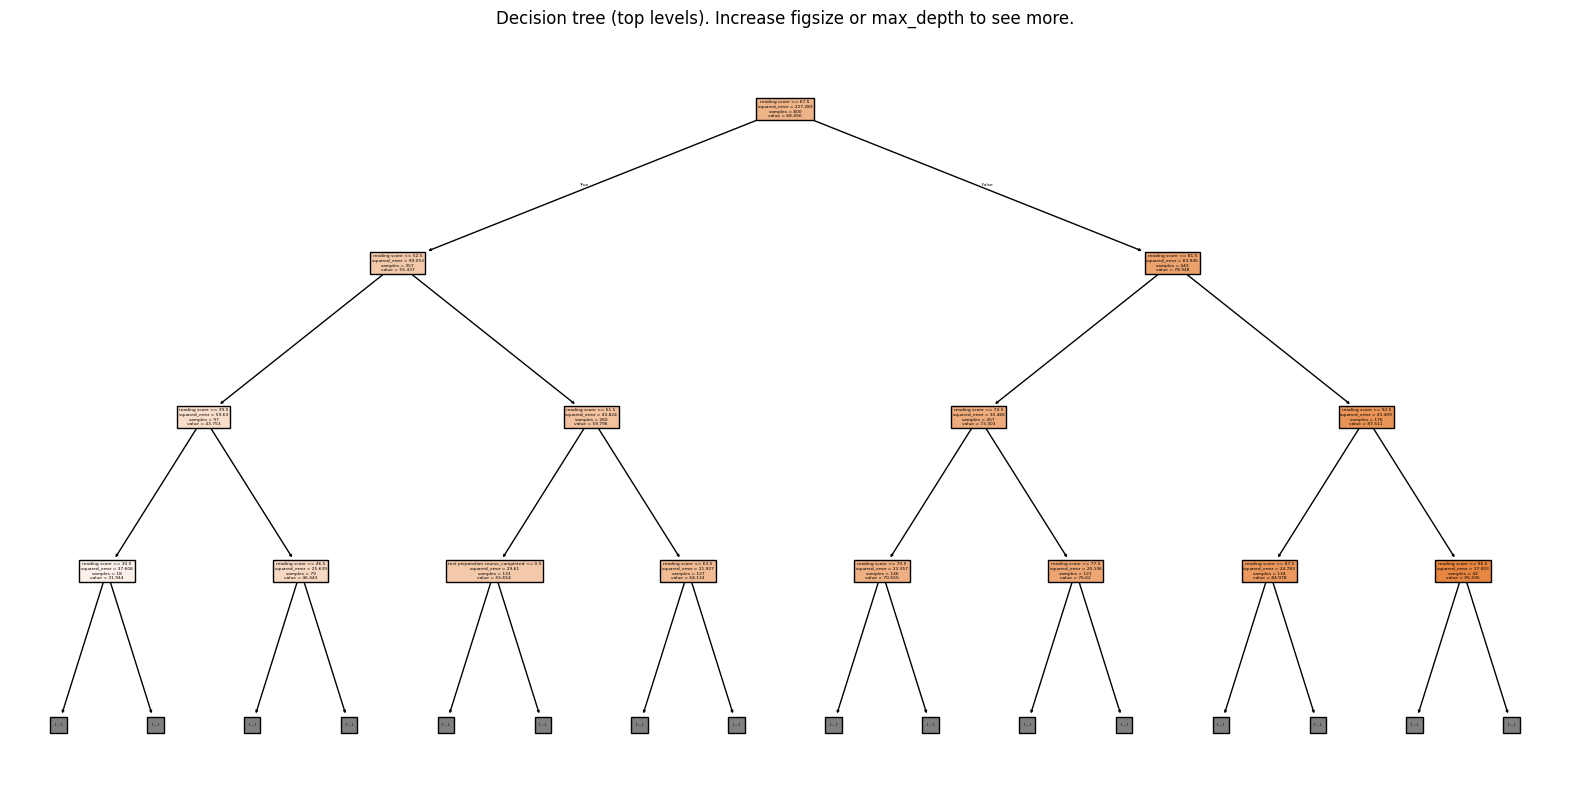

reading score: 0.9865
test preparation course_completed: 0.0055
math score: 0.0023
race/ethnicity_group D: 0.0020
parental level of education_some high school: 0.0014
race/ethnicity_group B: 0.0007
race/ethnicity_group E: 0.0007
race/ethnicity_group C: 0.0004
parental level of education_high school: 0.0004
parental level of education_associate's degree: 0.0002


In [16]:
# 11.1 - Get preprocessed feature names (for onehot)
# This is a bit fiddly: we extract feature names from the preprocessor
def get_feature_names_from_column_transformer(ct):
    # adapted helper - works for our two-transformer setup
    output_features = []
    for name, transformer, columns in ct.transformers_:
        if name == 'remainder':
            continue
        if hasattr(transformer, 'named_steps') and 'onehot' in transformer.named_steps:
            ohe = transformer.named_steps['onehot']
            cols = list(ohe.get_feature_names_out(columns))
            output_features.extend(cols)
        else:
            # numeric or other simple transformers
            output_features.extend(columns)
    return output_features

feat_names = get_feature_names_from_column_transformer(best_model.named_steps['pre'])
print("Feature names count:", len(feat_names))

# 11.2 - Extract the decision tree inside the pipeline
tree = best_model.named_steps['model']

# 11.3 - Plot tree (matplotlib)
from sklearn import tree as sktree
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
sktree.plot_tree(tree, feature_names=feat_names, class_names=None if not is_classification else [str(c) for c in sorted(set(y))], filled=True, max_depth=3)
plt.title("Decision tree (top levels). Increase figsize or max_depth to see more.")
plt.show()

# 11.4 - Feature importances
import numpy as np
if hasattr(tree, 'feature_importances_'):
    fi = tree.feature_importances_
    idx = np.argsort(fi)[::-1][:20]  # top 20
    for i in idx:
        if fi[i] > 0:
            print(f"{feat_names[i]}: {fi[i]:.4f}")


In [17]:
import joblib
os.makedirs("model_artifacts", exist_ok=True)
joblib.dump(best_model, "model_artifacts/decision_tree_pipeline.joblib")
print("Saved model to model_artifacts/decision_tree_pipeline.joblib")

# Save the predictions and evaluation summary
import json
eval_summary = {
    "best_params": gs.best_params_,
    "best_cv_score": float(gs.best_score_),
    "test_score_on_holdout": float(accuracy_score(y_test, y_pred_best) if is_classification else mean_squared_error(y_test, y_pred_best))
}
with open("model_artifacts/eval_summary.json", "w") as f:
    json.dump(eval_summary, f, indent=2)
print("Saved evaluation summary to model_artifacts/eval_summary.json")


Saved model to model_artifacts/decision_tree_pipeline.joblib
Saved evaluation summary to model_artifacts/eval_summary.json
